In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [130]:
df = pd.read_csv('../data/data_PETR4.SA.csv')
df.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-12-01 00:00:00-02:00,2.108028,2.132764,2.047563,2.058557,35865600,0.0,0.0
1,2015-12-02 00:00:00-02:00,2.072299,2.086041,2.020080,2.066803,47713500,0.0,0.0
2,2015-12-03 00:00:00-02:00,2.195977,2.245448,2.141009,2.193228,76680900,0.0,0.0
3,2015-12-04 00:00:00-02:00,2.190481,2.190481,2.039318,2.066803,63662600,0.0,0.0
4,2015-12-07 00:00:00-02:00,2.088790,2.091538,1.965111,1.976105,47395000,0.0,0.0
5,2015-12-08 00:00:00-02:00,1.978853,1.978853,1.910143,1.959614,46590500,0.0,0.0
6,2015-12-09 00:00:00-02:00,2.017331,2.149255,1.998092,2.102532,82102800,0.0,0.0
7,2015-12-10 00:00:00-02:00,2.064055,2.080545,2.009086,2.047564,43458400,0.0,0.0
8,2015-12-11 00:00:00-02:00,1.995344,2.069551,1.981602,1.992595,50750600,0.0,0.0
9,2015-12-14 00:00:00-02:00,1.965111,1.987098,1.943124,1.981601,33538000,0.0,0.0


In [131]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.date
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-12-01,2.108028,2.132764,2.047563,2.058557,35865600,0.0,0.0
1,2015-12-02,2.072299,2.086041,2.020080,2.066803,47713500,0.0,0.0
2,2015-12-03,2.195977,2.245448,2.141009,2.193228,76680900,0.0,0.0
3,2015-12-04,2.190481,2.190481,2.039318,2.066803,63662600,0.0,0.0
4,2015-12-07,2.088790,2.091538,1.965111,1.976105,47395000,0.0,0.0


In [132]:
df['Variacao'] =  (df['Open'] - df['Close']) / df['Open']
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Variacao
0,2015-12-01,2.108028,2.132764,2.047563,2.058557,35865600,0.0,0.0,0.023468
1,2015-12-02,2.072299,2.086041,2.020080,2.066803,47713500,0.0,0.0,0.002653
2,2015-12-03,2.195977,2.245448,2.141009,2.193228,76680900,0.0,0.0,0.001252
3,2015-12-04,2.190481,2.190481,2.039318,2.066803,63662600,0.0,0.0,0.056462
4,2015-12-07,2.088790,2.091538,1.965111,1.976105,47395000,0.0,0.0,0.053947


In [133]:
variation = [df['Variacao'] == 0,
            df['Variacao'] > 0,
            df['Variacao'] < 0]

colours = ['blue', 'green', 'red']

colours_np = np.select(variation, colours, default='black')


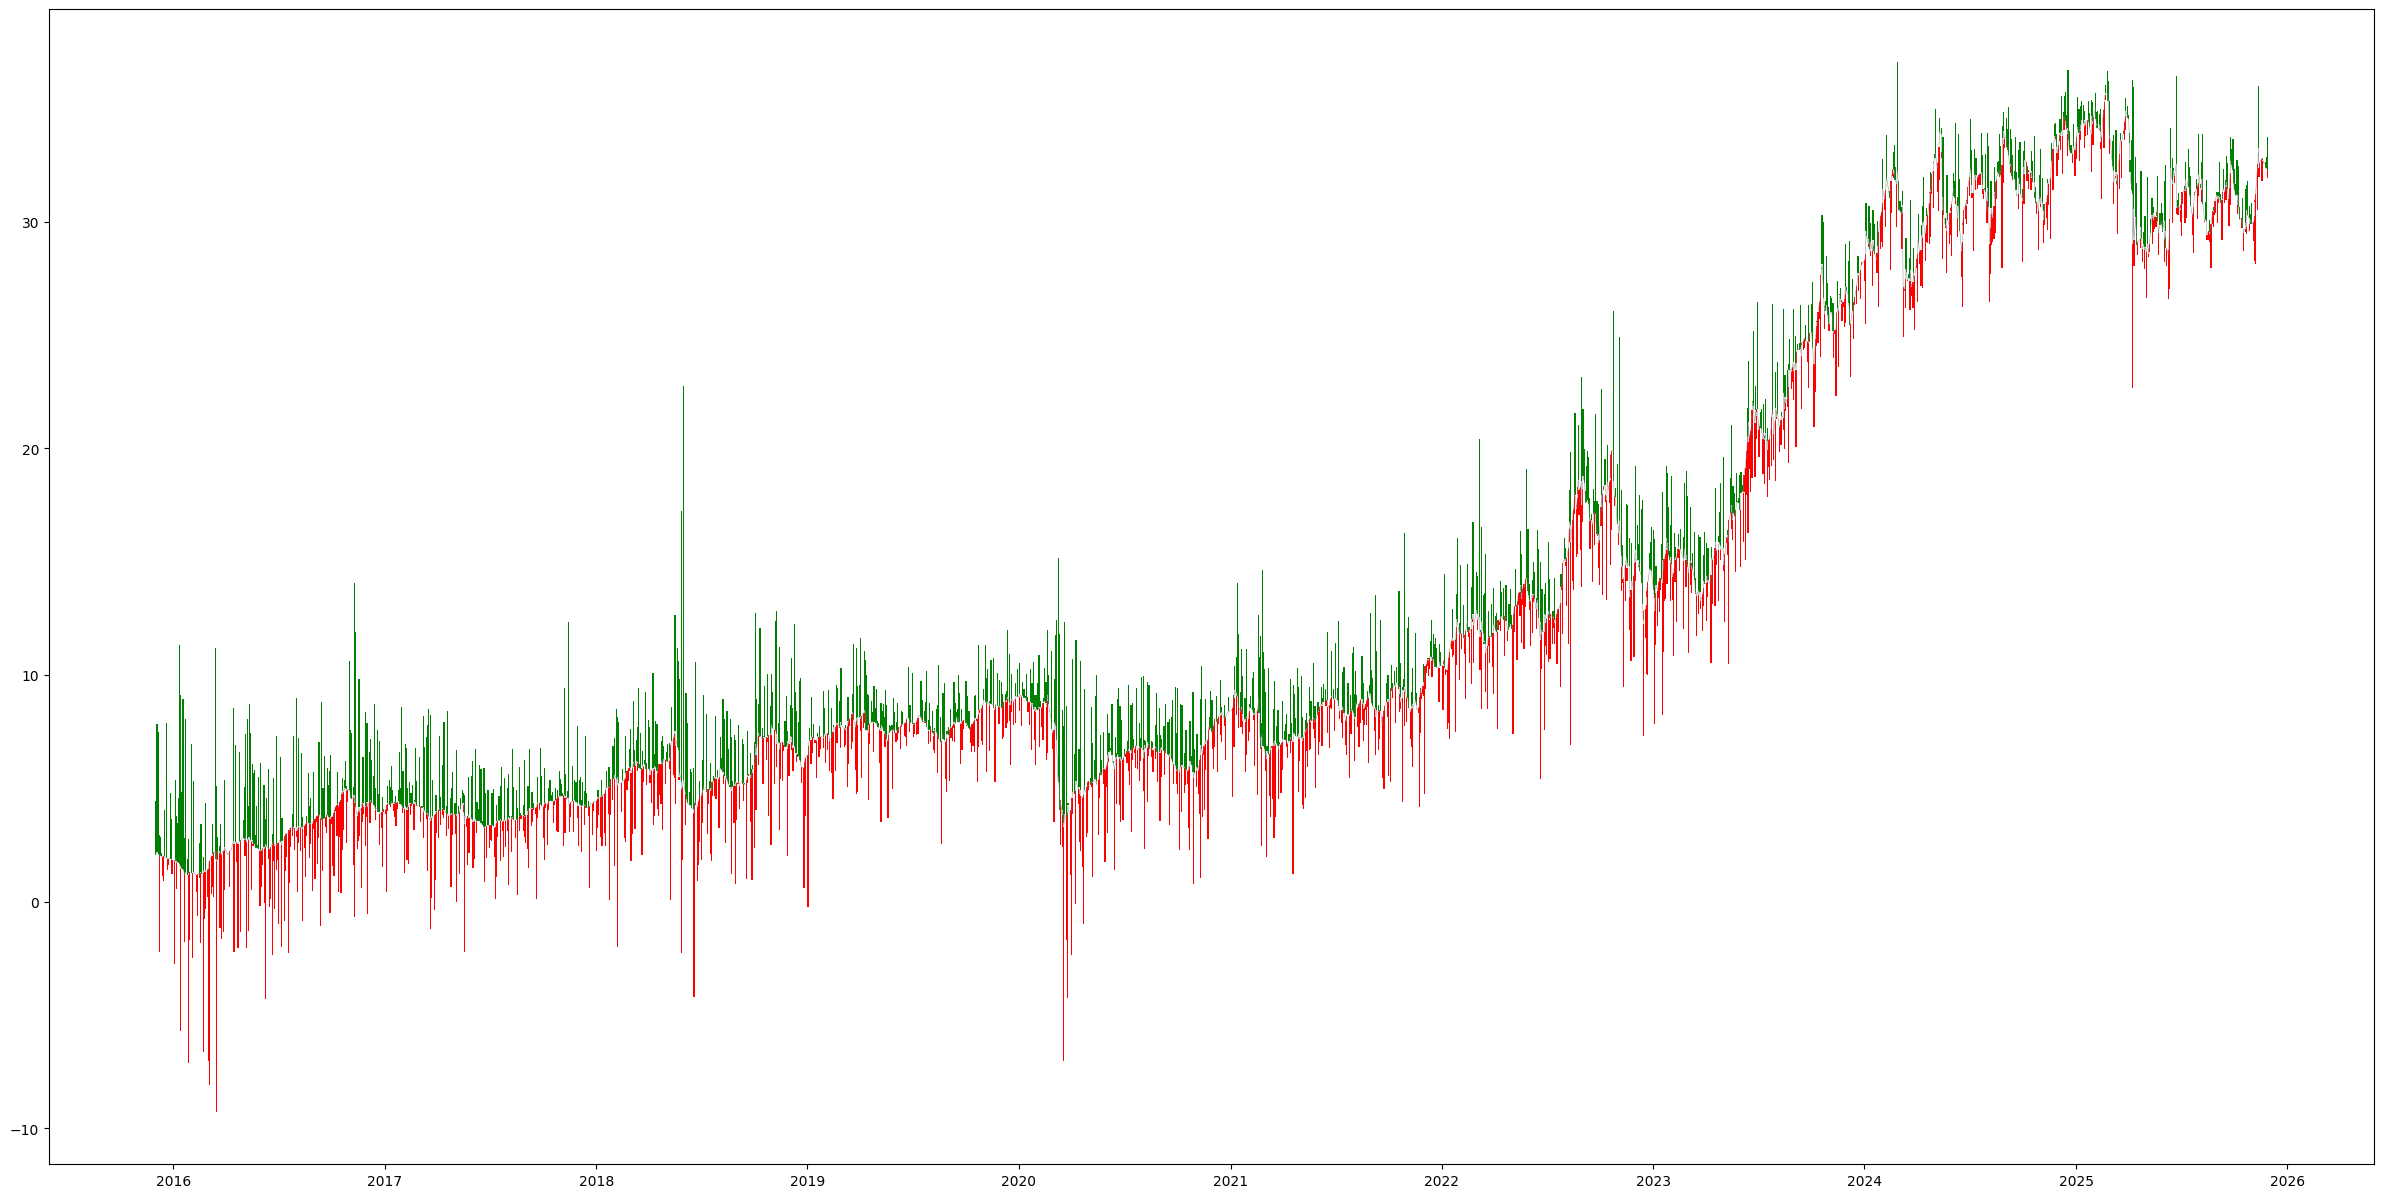

In [134]:
plt.figure(figsize=(30, 15))
plt.bar(df['Date'], df['Variacao'] * 100, bottom=df['Open'], color=colours_np, width = 2)
plt.plot(df['Date'], df['Open'], linewidth = 0.3, color='grey')
plt.show()

In [135]:
plt.clf()
higher = np.where(np.abs(df['Variacao'])> 0.02)
df_higher = df.loc[higher]
df_higher.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Variacao
0,2015-12-01,2.108028,2.132764,2.047563,2.058557,35865600,0.0,0.0,0.023468
3,2015-12-04,2.190481,2.190481,2.039318,2.066803,63662600,0.0,0.0,0.056462
4,2015-12-07,2.088790,2.091538,1.965111,1.976105,47395000,0.0,0.0,0.053947
6,2015-12-09,2.017331,2.149255,1.998092,2.102532,82102800,0.0,0.0,-0.042234
12,2015-12-17,2.020079,2.066802,1.976105,1.978853,43789300,0.0,0.0,0.020408


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

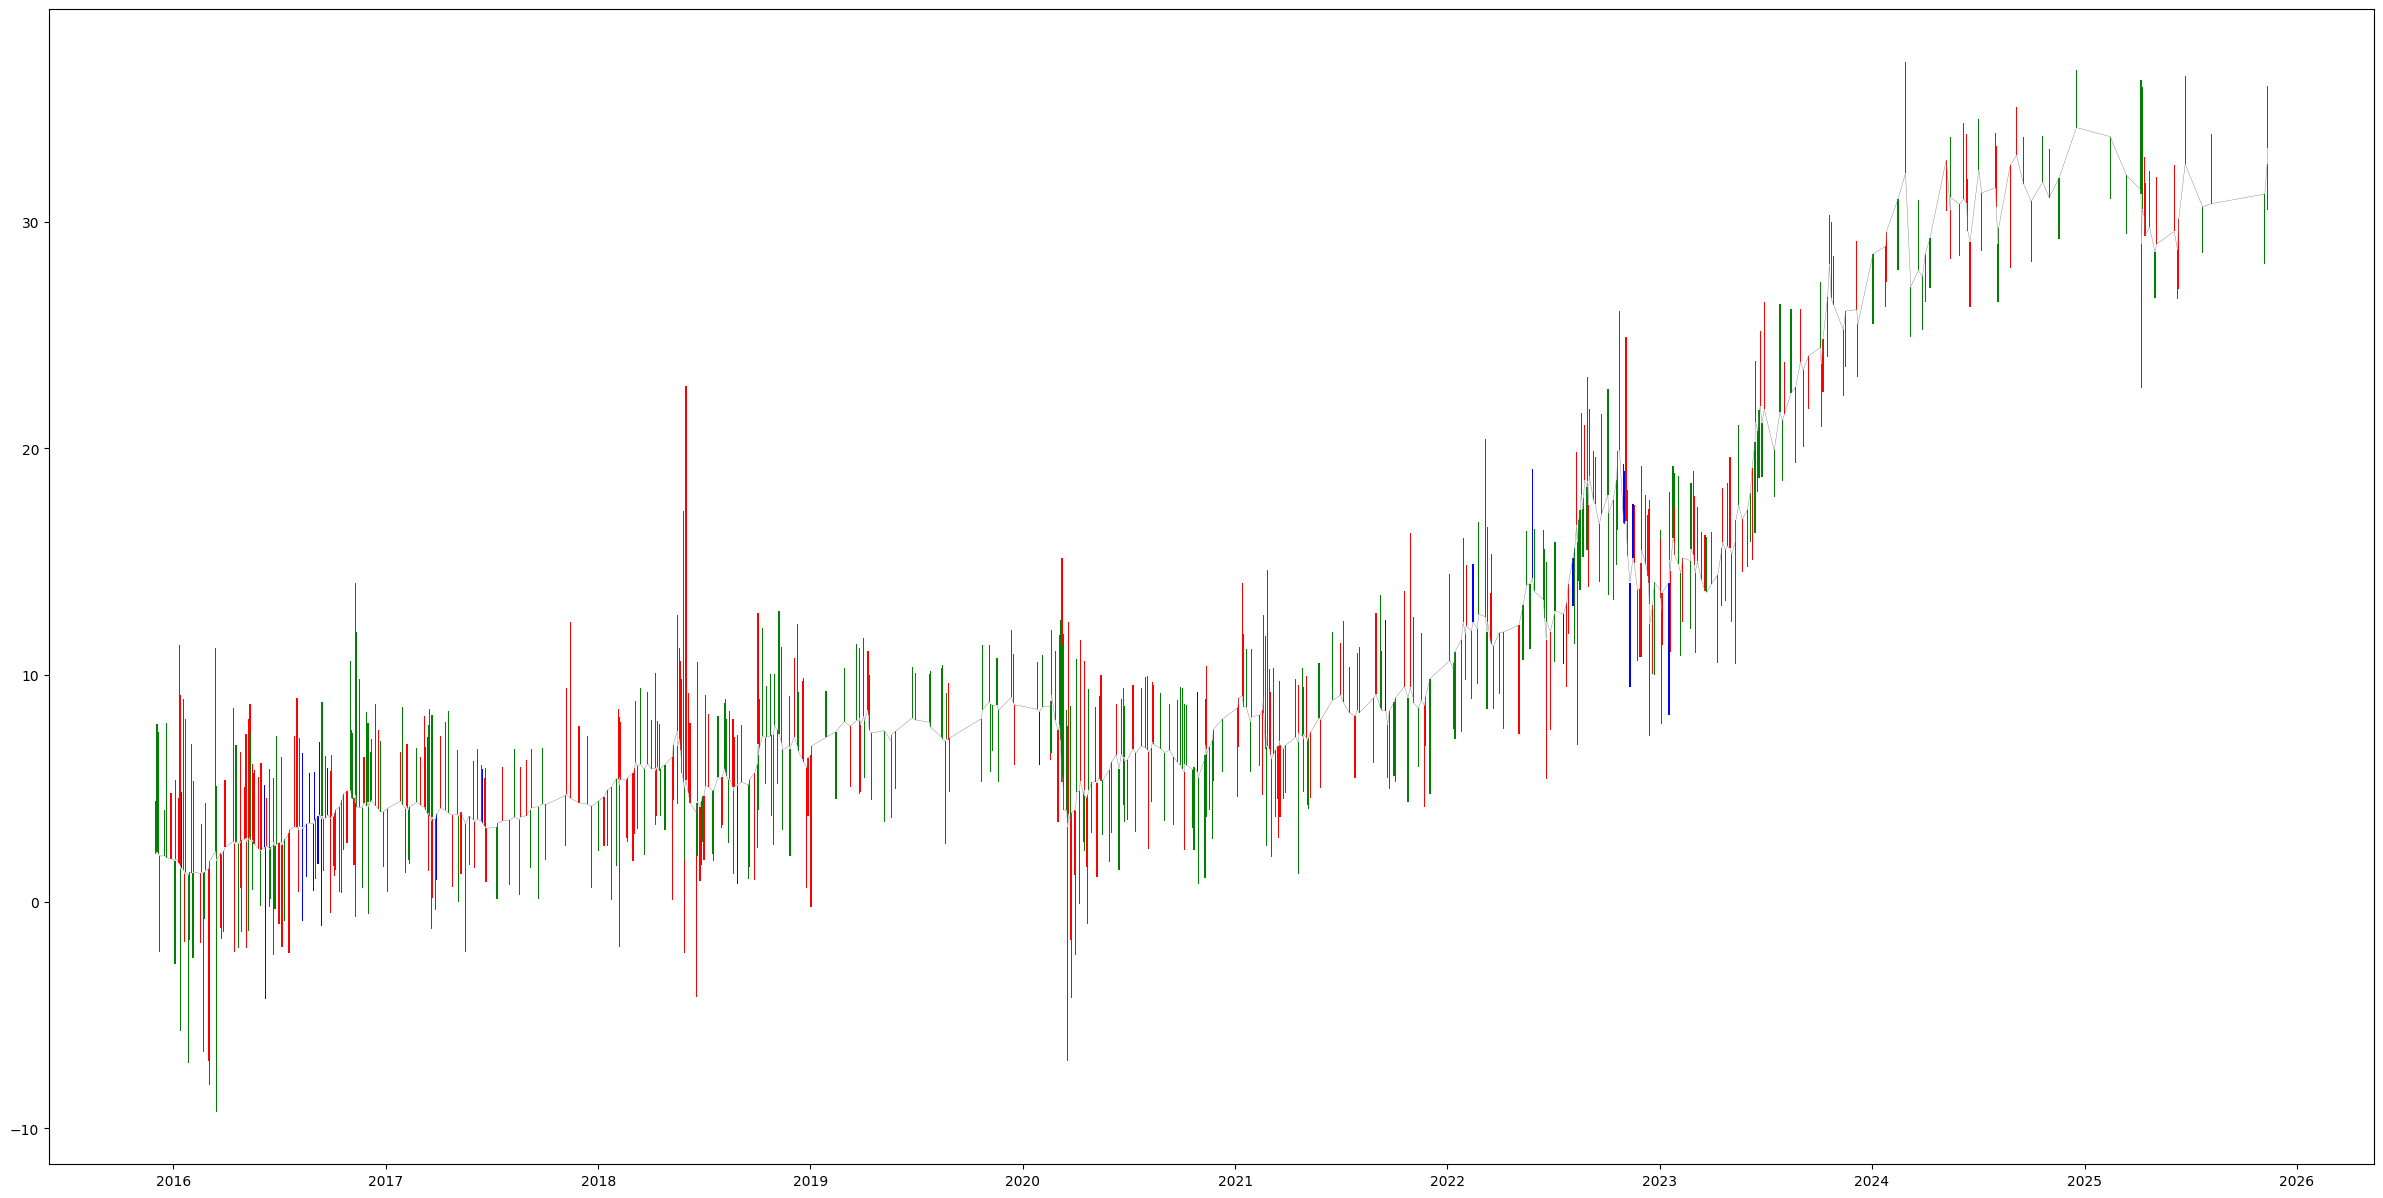

In [136]:
plt.clf()
plt.figure(figsize=(30, 15))
plt.bar(df_higher['Date'], df_higher['Variacao'] * 100, bottom=df_higher['Open'], color=colours_np, width = 2)
plt.plot(df_higher['Date'], df_higher['Open'], linewidth = 0.3, color='grey')
plt.show()

In [137]:
df_higher[['Date', 'Variacao']]

,Date,Variacao
0,2015-12-01,0.023468
3,2015-12-04,0.056462
4,2015-12-07,0.053947
6,2015-12-09,-0.042234
12,2015-12-17,0.020408
...,...,...
2399,2025-07-23,-0.020415
2411,2025-08-08,0.030794
2476,2025-11-07,-0.030750
2478,2025-11-11,-0.020283
